# Introduction


In this notebook, we explore various Convolutional Neural Network (CNN) architectures to perform sentiment analysis on the IMDb dataset. The IMDb dataset, widely used in NLP research, contains 50,000 movie reviews labeled as positive or negative.

Unlike traditional NLP approaches that rely on text processing techniques, in this study, the sentences are represented as sequences of integers. Each word in a review is mapped to an index based on its frequency in the dataset, transforming the text into a numerical sequence. These sequences are then padded to ensure a uniform length, making them suitable for CNN processing.

### Models Compared in This Study
We evaluate and compare different architectures implemented in TensorFlow/Keras and PyTorch:

* Keras Sequential CNN – A simple CNN built using Keras' Sequential API.
* Keras Functional API CNN – A more flexible model leveraging Keras' Functional API.
* Keras CNN with Multiple Filter Sizes – A model incorporating different convolutional filter sizes for better feature extraction.
* PyTorch CNN – A deep learning model built using PyTorch.

### Study Objective
The goal of this work is not necessarily to find the best possible model, but rather to analyze and compare different CNN architectures for sentiment classification.

It is important to note that:

Performance may vary depending on hyperparameters, dataset preprocessing, and training strategies.
CNNs are not the only approach for sentiment analysis; other models, such as Recurrent Neural Networks (RNNs) and Transformers (BERT), often perform better for long-text understanding.
However, CNNs remain effective for capturing local patterns in sequences, making them a reasonable choice for text classification.

In [19]:
import numpy as np

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

from tensorflow.keras   import layers
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, Conv2D, MaxPooling2D, MaxPooling1D, GlobalMaxPool1D
from tensorflow.keras.layers import Embedding, Input, Activation, BatchNormalization, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam

#from tensorflow.keras.datasets import imdb
from tensorflow.keras.datasets import imdb
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import time

In [20]:
# Use the default parameters to keras.datasets.imdb.load_data
MAX_SEQUENCE_LENGTH = 500  # all text-sequences are padded to this length
MAX_NB_WORDS = 10000        # number of most-frequent words that are regarded, all others are ignored
EMBEDDING_DIM = 100         # dimension of word-embedding
INDEX_FROM = 3 # Define INDEX_FROM
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=MAX_NB_WORDS,index_from=INDEX_FROM)

In [21]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(25000,)
(25000,)
(25000,)
(25000,)


In [22]:
print(X_train[0][:10])
print(y_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]
1


In [23]:
# Padding sequences for uniform shape
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")

# Ensure X_train is a NumPy array
X_train = np.array(X_train, dtype=np.int32)
X_test = np.array(X_test, dtype=np.int32)

print(" X_train after padding:")
print("X_train shape:", X_train.shape)  # Expected: (25000, 500)
print("X_train dtype:", X_train.dtype)  # Expected: int32

 X_train after padding:
X_train shape: (25000, 500)
X_train dtype: int32


In [24]:
# Vérifier si y_train est one-hot ou en classes
if len(y_train.shape) > 1 and y_train.shape[1] > 1:
    print("y_train is already one-hot encoded.")
else:
    y_train = to_categorical(y_train, num_classes=2)
    y_test = to_categorical(y_test, num_classes=2)
    print("Converted y_train to one-hot encoding.")


Converted y_train to one-hot encoding.


In [25]:
import numpy as np

def adapt_labels_for_model(model, y_train, y_test):
    """
    Converts labels to match the model's expected output shape.

    Args:
        model (keras.Model): The model for which labels should be formatted.
        y_train (np.array): Training labels.
        y_test (np.array): Test labels.

    Returns:
        y_train (np.array), y_test (np.array): Labels formatted to match model output.
    """

    # If the model expects a single output neuron (binary classification)
    if model.output_shape[-1] == 1:
        # Convert one-hot encoded labels (if applicable) into single-class labels (0 or 1)
        if len(y_train.shape) > 1 and y_train.shape[1] > 1:
            y_train = np.argmax(y_train, axis=-1)
            y_test = np.argmax(y_test, axis=-1)

        # Reshape to (batch_size, 1)
        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)

        print(f"✅ Model `{model.name}` expects binary labels. Reshaped y_train to: {y_train.shape}")

    else:
        # If the model expects multiple classes, keep labels as one-hot encoded
        print(f"✅ Model `{model.name}` expects one-hot labels. No changes needed.")

    return y_train, y_test

def check_data_shapes(X_train, y_train, model):
    print(f"\nChecking shapes for model: {model.name}")
    print(f"X_train shape: {X_train.shape}, Expected: {model.input_shape}")
    print(f"y_train shape: {y_train.shape}, Expected: {model.output_shape}")

In [26]:
embedding_layer = Embedding(MAX_NB_WORDS,  # Vocabulary size
                            EMBEDDING_DIM,  # Embedding vector dimension
                            input_length=MAX_SEQUENCE_LENGTH,  # Maximum sequence length
                            trainable=True   # Allow the embedding layer to be trainable
                            )

In [27]:
def fit_model(model, train_data, test_data, epochs=10, batch_size=32):
    """
    Trains a Keras model and measures execution time.

    Args:
        model (keras.Model): The Keras model to train.
        train_data (tuple): Tuple (X_train, y_train) containing training data.
        test_data (tuple): Tuple (X_test, y_test) containing validation data.
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.

    Returns:
        history (History): Keras training history object.
        training_time (float): Time taken for training.
    """

    X_train, y_train = train_data
    X_test, y_test = test_data

    # Check data shapes before training
    print(f"\n Training model: {model.name}")
    print(f"X_train shape: {X_train.shape}, Expected: {model.input_shape}")
    print(f"y_train shape: {y_train.shape}, Expected: {model.output_shape}")

    # Ensure `y_train` and `y_test` match the model's expected output shape
    if y_train.shape[-1] != model.output_shape[-1]:
        raise ValueError(f" Mismatch: Model expects y_train of shape {model.output_shape}, but got {y_train.shape}")

    start_time = time.time()
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )
    training_time = time.time() - start_time
    print(f"\n Training complete! Time taken: {training_time:.2f} seconds")

    return history, training_time


In [39]:
def plot_history(history):
    """
    Plots loss and accuracy curves from a Keras training history.

    Args:
        history (History): Keras training history object.
    """

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # Loss curve
    ax[0].plot(history.history['loss'], label='Train Loss')
    ax[0].plot(history.history['val_loss'], label='Validation Loss')
    ax[0].set_title('Loss Curve')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    # Determine whether to use `accuracy` or `categorical_accuracy`
    accuracy_key = 'accuracy' if 'accuracy' in history.history else 'categorical_accuracy'

    # Accuracy curve
    ax[1].plot(history.history[accuracy_key], label='Train Accuracy')
    ax[1].plot(history.history[f'val_{accuracy_key}'], label='Validation Accuracy')
    ax[1].set_title('Accuracy Curve')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.show()


In [29]:
def evaluate_model(model, test_data):
    """
    Evaluates a trained Keras model on a test dataset and prints evaluation metrics.

    Args:
        model (keras.Model): The trained Keras model.
        test_data (tuple): Tuple (X_test, y_test) containing test data.

    Returns:
        None (prints classification report and confusion matrix).
    """

    X_test, y_test = test_data
    y_pred_proba = model.predict(X_test)

    #  Check if the model is binary or multi-class
    if y_pred_proba.shape[-1] == 1:
        y_pred = (y_pred_proba > 0.5).astype(int).flatten() # Convert probabilities to 0/1 classe
        y_true = y_test.flatten()
    else:
        y_pred = np.argmax(y_pred_proba, axis=1)  # Convert probabilities to class labels
        y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class labels


    print("\n Classification Report :\n", classification_report(y_true, y_pred))
    print("\n Confusion Matrix :\n", confusion_matrix(y_true, y_pred))

In [30]:
def check_data_shapes(X_train, y_train, model):
    """
    Checks if the input and output shapes match the model's expected dimensions.

    Args:
        X_train (np.array): Training input data.
        y_train (np.array): Training labels.
        model (keras.Model): The model to validate.

    Returns:
        None (prints validation results).
    """
    print(f"\n Checking shapes for model: {model.name}")
    print(f"X_train shape: {X_train.shape}, Expected: {model.input_shape}")
    print(f"y_train shape: {y_train.shape}, Expected: {model.output_shape}")


# CNN sequentiel with 2 layers conv and embeddings

In [54]:
# Rebuild model_seq
model_seq = keras.Sequential([
    layers.Embedding(input_dim=10000, output_dim=128, input_length=500, mask_zero=True, name="embedding_layer"),

    layers.Conv1D(filters=64, kernel_size=5, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.MaxPooling1D(pool_size=2),

    layers.GlobalMaxPooling1D(),
    layers.Dropout(0.3),

    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.3),

    layers.Dense(1, activation='sigmoid', name="output_layer")
])

model_seq.build(input_shape=(None, 500))  # ✅ Define input shape manually


# Compile again
model_seq.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_10' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [52]:
model_seq = keras.Sequential([
    layers.Embedding(input_dim=10000, output_dim=128, input_length=500, mask_zero=True, name="embedding_layer"),  # ✅ Explicit input_length
    layers.Conv1D(filters=64, kernel_size=5, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.MaxPooling1D(pool_size=2),
    layers.GlobalMaxPooling1D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid', name="output_layer")
])

model_seq.build(input_shape=(None, 500))  # ✅ Define input shape manually



In [55]:
model_seq.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy'])
model_seq.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)          │ (None, 500, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ (None, 496, 64)             │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 496, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_10 (MaxPooling1D)      │ (None, 248, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 246, 64)             │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_11 (MaxPooling1D)      │ (None, 123, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_5               │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,342,081 (5.12 MB)

 Trainable params: 1,341,953 (5.12 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
print("X_train shape:", X_train.shape)  # Expected: (25000, 500)
print("X_train dtype:", X_train.dtype)  # Expected: int32 or float32


X_train shape: (25000, 500)
X_train dtype: int32


In [35]:
y_train_seq, y_test_seq = adapt_labels_for_model(model_seq, y_train, y_test)

# Convert y_train_seq and y_test_seq to float32
y_train_seq = y_train_seq.astype(np.float32)
y_test_seq = y_test_seq.astype(np.float32)

# Verify dtype
print("Final y_train_seq dtype:", y_train_seq.dtype)


✅ Model `sequential_1` expects binary labels. Reshaped y_train to: (25000, 1)
Final y_train_seq dtype: float32


In [56]:
# Train `model_seq` (binary classification, sigmoid activation)
history_seq, training_time_seq = fit_model(model_seq, train_data=(X_train, y_train_seq), test_data=(X_test, y_test_seq))



 Training model: sequential_5
X_train shape: (25000, 500), Expected: (None, 500)
y_train shape: (25000, 1), Expected: (None, 1)
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.5089 - loss: 2.8854 - val_accuracy: 0.5023 - val_loss: 2.1635
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5593 - loss: 1.9778 - val_accuracy: 0.7262 - val_loss: 1.4671
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7349 - loss: 1.3103 - val_accuracy: 0.8484 - val_loss: 0.8841
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8623 - loss: 0.8153 - val_accuracy: 0.8722 - val_loss: 0.6615
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9087 - loss: 0.5725 - val_accuracy: 0.8728 - val_loss: 0.5579
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9341 - loss: 0.4278 - val_accuracy: 0.8722 - val_loss: 0.5057
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9590 - loss: 0.3207 - val_accurac

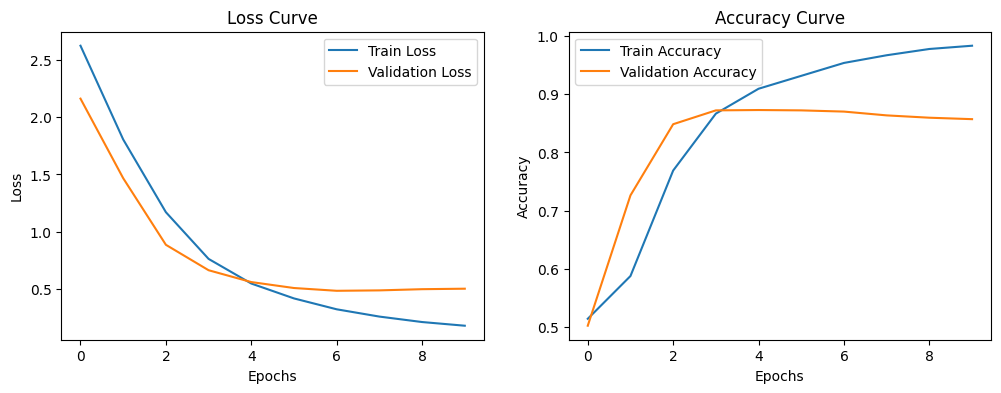

In [58]:
plot_history(history_seq)

In [60]:
evaluate_model(model_seq, (X_test, y_test_seq))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d_10' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

 Classification Report :
               precision    recall  f1-score   support

         0.0       0.85      0.87      0.86     12500
         1.0       0.87      0.84      0.85     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000


 Confusion Matrix :
 [[10897  1603]
 [ 1970 10530]]


# CNN with API

In [61]:
# Define Model input
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name="sequence_input")

# Embedding Layer
embedded_sequences = embedding_layer(sequence_input)

# First Convolution Block
conv1 = layers.Conv1D(filters=32, kernel_size=5, activation='relu', name="conv1")(embedded_sequences)
pool1 = layers.MaxPooling1D(pool_size=2, name="pool1")(conv1)

# Second Convolution Block
conv2 = layers.Conv1D(filters=64, kernel_size=3, activation='relu', name="conv2")(pool1)
pool2 = layers.MaxPooling1D(pool_size=2, name="pool2")(conv2)

# Global Max Pooling Laye (reduces dimensionality)
global_pool = layers.GlobalMaxPooling1D(name="global_pool")(pool2)

# Fully connected Layer
dense = layers.Dense(64, activation='relu', name="dense_layer")(global_pool)
dropout = layers.Dropout(0.3, name="dropout")(dense)

# Output Layer for Binary Classification
output = layers.Dense(2, activation='sigmoid', name="output_layer")(dropout)

# Model Definition using Functional API
model_api = Model(inputs=sequence_input, outputs=output, name="CNN_API_Model")

# Compile the Model
model_api.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['categorical_accuracy'])

# Display Model summary
model_api.summary()

Model: "CNN_API_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequence_input (InputLayer)          │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 500, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv1D)                       │ (None, 496, 32)             │          16,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling1D)                 │ (None, 248, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv1D)                       │ (None, 246, 64)             │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling1D)                 │ (None, 123, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_pool (GlobalMaxPooling1D)     │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer (Dense)                  │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,026,530 (3.92 MB)

 Trainable params: 1,026,530 (3.92 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
y_train_api, y_test_api = adapt_labels_for_model(model_api, y_train, y_test)


✅ Model `CNN_API_Model` expects one-hot labels. No changes needed.


In [63]:
history_api, training_time_api = fit_model(
    model_api, train_data=(X_train, y_train_api), test_data=(X_test, y_test_api)
)



 Training model: CNN_API_Model
X_train shape: (25000, 500), Expected: (None, 500)
y_train shape: (25000, 2), Expected: (None, 2)
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - categorical_accuracy: 0.6387 - loss: 0.5993 - val_categorical_accuracy: 0.8572 - val_loss: 0.3311
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - categorical_accuracy: 0.8741 - loss: 0.3042 - val_categorical_accuracy: 0.8500 - val_loss: 0.3654
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - categorical_accuracy: 0.9151 - loss: 0.2233 - val_categorical_accuracy: 0.8437 - val_loss: 0.3943
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - categorical_accuracy: 0.9462 - loss: 0.1488 - val_categorical_accuracy: 0.8892 - val_loss: 0.2759
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - categorical_accuracy: 0.9665 - loss: 0.0986 - val_categorical_accuracy: 0.8945 - val_loss: 0.3094
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - categorical_accuracy: 0.9845 - loss: 0.0498 - va

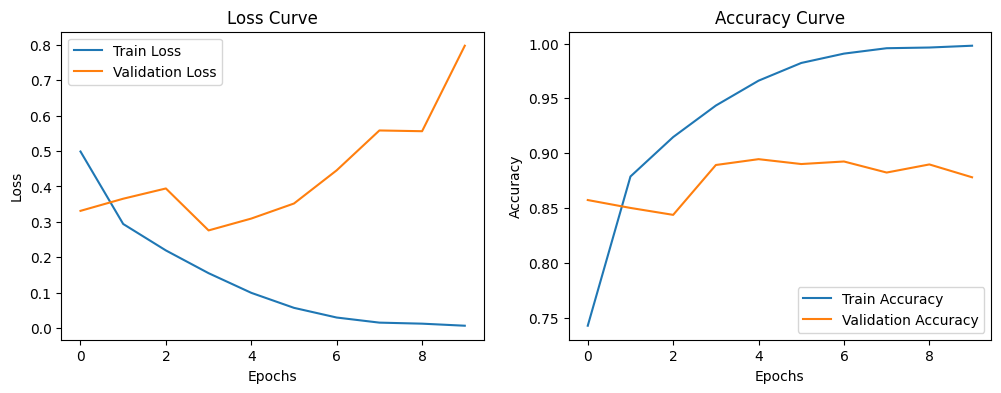

In [64]:
plot_history(history_api)

In [65]:
evaluate_model(model_api, (X_test, y_test))
print(f"Temps total d'entraînement : {training_time_api:.2f} secondes")

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

 Classification Report :
               precision    recall  f1-score   support

           0       0.93      0.81      0.87     12500
           1       0.83      0.94      0.89     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000


 Confusion Matrix :
 [[10159  2341]
 [  709 11791]]
Temps total d'entraînement : 112.50 secondes


CNN withs different filters

In [66]:
from warnings import filters


In [67]:
# # Convertir y_train et y_test en format one-hot
# y_train = to_categorical(y_train, num_classes=2)
# y_test = to_categorical(y_test, num_classes=2)

# Paramètres
# MAX_SEQUENCE_LENGTH = 500
# MAX_NB_WORDS = 10000
# EMBEDDING_DIM = 100

# Define Model input
input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))

# Embedding Layer
embedding_layer = Embedding(input_dim=MAX_NB_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(input_layer)

# First Convolutional Block (3x3 kernel)
conv_3 = Conv1D(filters=32, kernel_size=3, activation=None)(embedding_layer)  # Pas d'activation ici !
conv_3 = BatchNormalization()(conv_3)  # Normalisation après convolution
conv_3 = Activation('relu')(conv_3)  # ReLU après normalisation
pool_3 = MaxPooling1D(pool_size=4)(conv_3)

# Second Convolutional Block (4x4 kernel)
conv_4 = Conv1D(filters=32, kernel_size=4, activation=None)(embedding_layer)  # Pas d'activation ici !
conv_4 = BatchNormalization()(conv_4)  # Normalisation après convolution
conv_4 = Activation('relu')(conv_4)  # ReLU après normalisation
pool_4 = MaxPooling1D(pool_size=4)(conv_4)

# Third Convolutional Block (5x5 kernel)
conv_5 = Conv1D(filters=32, kernel_size=5, activation=None)(embedding_layer)  # Pas d'activation ici !
conv_5 = BatchNormalization()(conv_5)  # Normalisation après convolution
conv_5 = Activation('relu')(conv_5)  # ReLU après normalisation
pool_5 = MaxPooling1D(pool_size=4)(conv_5)

# Concatenate extracted features from all convolutional branches
merged = Concatenate()([pool_3, pool_4, pool_5])

#Additional Convolutional Layer after merging
conv2 = Conv1D(filters=64, kernel_size=3, activation='relu')(merged)
pool2 = GlobalMaxPool1D()(conv2)

# Flatten before Fully Connected
flat = Flatten()(pool2)

# Fully Connected Layers
dense_layer = Dense(64, activation='relu')(flat)
dropout_layer = Dropout(0.5)(dense_layer)  # Dropout pour éviter l'overfitting

# Output Layer for Multi-Class Classification (Softmax)
output_layer = Dense(2, activation='softmax')(dropout_layer)   # Sortie en one-hot encoding


# Define The Keras Model
model_filters = Model(inputs=input_layer, outputs=output_layer)

# Compile the Model
model_filters.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['categorical_accuracy'])

# Display Model summary
model_filters.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 500)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 500, 100)       │      1,000,000 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_12 (Conv1D)        │ (None, 498, 32)        │          9,632 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_13 (Conv1D)        │ (None, 497, 32)        │         12,832 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_14 (Conv1D)        │ (None, 496, 32)        │         16,032 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 498, 32)        │            128 │ conv1d_12[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 497, 32)        │            128 │ conv1d_13[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 496, 32)        │            128 │ conv1d_14[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 498, 32)        │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 497, 32)        │              0 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 496, 32)        │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_12          │ (None, 124, 32)        │              0 │ activation[0][0]       │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_13          │ (None, 124, 32)        │              0 │ activation_1[0][0]     │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_14          │ (None, 124, 32)        │              0 │ activation_2[0][0]     │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 124, 96)        │              0 │ max_pooling1d_12[0][0… │
│                           │                        │                │ max_pooling1d_13[0][0… │
│                           │                        │                │ max_pooling1d_14[0][0] │
├──────────────────────

 Total params: 1,061,666 (4.05 MB)

 Trainable params: 1,061,474 (4.05 MB)

 Non-trainable params: 192 (768.00 B)

In [68]:
y_train_filters, y_test_filters = adapt_labels_for_model(model_filters, y_train, y_test)


✅ Model `functional_3` expects one-hot labels. No changes needed.


In [69]:
history_filters, training_time_filters = fit_model(
    model_filters, train_data=(X_train, y_train_filters), test_data=(X_test, y_test_filters)
)



 Training model: functional_3
X_train shape: (25000, 500), Expected: (None, 500)
y_train shape: (25000, 2), Expected: (None, 2)
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 54s 58ms/step - categorical_accuracy: 0.6268 - loss: 0.6267 - val_categorical_accuracy: 0.8329 - val_loss: 0.3956
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step - categorical_accuracy: 0.8795 - loss: 0.2968 - val_categorical_accuracy: 0.8846 - val_loss: 0.2755
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - categorical_accuracy: 0.9233 - loss: 0.2035 - val_categorical_accuracy: 0.8820 - val_loss: 0.3008
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 36s 47ms/step - categorical_accuracy: 0.9553 - loss: 0.1280 - val_categorical_accuracy: 0.8832 - val_loss: 0.3565
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - categorical_accuracy: 0.9746 - loss: 0.0791 - val_categorical_accuracy: 0.8672 - val_loss: 0.4340
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step - categorical_accuracy: 0.9859 - loss: 0.0462 -

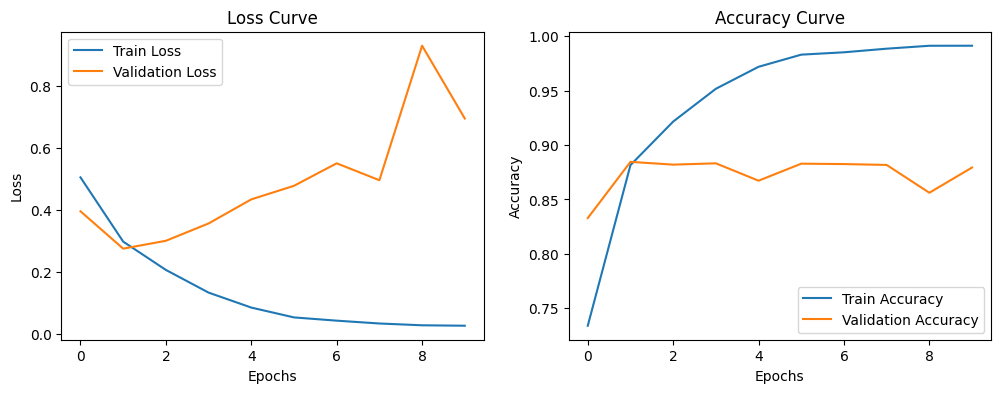

In [70]:
plot_history(history_filters)

In [72]:
evaluate_model(model_filters, (X_test,y_test_filters))

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

 Classification Report :
               precision    recall  f1-score   support

           0       0.87      0.89      0.88     12500
           1       0.88      0.87      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000


 Confusion Matrix :
 [[11075  1425]
 [ 1591 10909]]


# CNN with Pytorch

In [98]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report

In [112]:
# Define the PyTorch CNN model
class CNNClassifier(nn.Module):
    """
    A Convolutional Neural Network (CNN) model for text classification.

    Args:
        vocab_size (int): Number of unique words in the vocabulary.
        embed_dim (int): Size of word embedding vectors.
        num_classes (int): Number of output classes (2 for binary classification).
    """

    def __init__(self, vocab_size, embed_dim, num_classes):
        super(CNNClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.conv3 = nn.Conv1d(embed_dim, 32, kernel_size=3)
        self.conv4 = nn.Conv1d(embed_dim, 32, kernel_size=4)
        self.conv5 = nn.Conv1d(embed_dim, 32, kernel_size=5)
        self.pool = nn.MaxPool1d(kernel_size=4)
        self.conv_final = nn.Conv1d(96, 64, kernel_size=5)
        self.global_pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(64, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)

        x1 = self.pool(F.relu(self.conv3(x)))
        x2 = self.pool(F.relu(self.conv4(x)))
        x3 = self.pool(F.relu(self.conv5(x)))

        x = torch.cat((x1, x2, x3), dim=1)
        x = self.global_pool(F.relu(self.conv_final(x)))
        x = x.view(x.shape[0], -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


**Step 1: Instantiate Model, Loss, and Optimizer**

In [113]:
# Define model hyperparameters
MAX_SEQUENCE_LENGTH = 500
MAX_NB_WORDS = 10000
EMBEDDING_DIM = 100
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 0.0005

# Set device (use GPU if available)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model and move it to GPU/CPU
model_torch = CNNClassifier(vocab_size=MAX_NB_WORDS, embed_dim=EMBEDDING_DIM, num_classes=2).to(DEVICE)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_torch.parameters(), lr=LEARNING_RATE)



**Step 2: Train Model & Track Execution Time**

In [118]:
def train_model(model, train_loader, test_loader, optimizer, criterion, epochs):
    """
    Trains the CNN model, tracks train & validation loss/accuracy, and execution time.

    Args:
        model (torch.nn.Module): PyTorch model.
        train_loader (DataLoader): DataLoader for training.
        test_loader (DataLoader): DataLoader for validation (test set).
        optimizer (torch.optim.Optimizer): Optimizer.
        criterion (torch.nn.Module): Loss function.
        epochs (int): Number of epochs.

    Returns:
        history (dict): Dictionary containing train/validation loss & accuracy.
        training_time (float): Total training time in seconds.
    """

    model.train()
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    start_time = time.time()  # Record start time

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        # 🔹 Training Phase
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == targets.argmax(1)).sum().item()
            total += targets.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        # 🔹 Validation Phase (NEW: Evaluate on test_loader)
        val_loss, val_acc = evaluate_during_training(model, test_loader, criterion)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

    training_time = time.time() - start_time  # Compute execution time
    print(f"\nTotal Training Time: {training_time:.2f} seconds")

    return history, training_time


In [123]:
def evaluate_during_training(model, test_loader, criterion):
    """
    Evaluates the model on a test (validation) dataset and returns loss & accuracy.

    Args:
        model (torch.nn.Module): Trained PyTorch model.
        test_loader (DataLoader): DataLoader for validation data.
        criterion (torch.nn.Module): Loss function.

    Returns:
        Tuple (val_loss, val_accuracy)
    """

    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradients for faster evaluation
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            correct += (outputs.argmax(1) == targets.argmax(1)).sum().item()
            total += targets.size(0)

    val_loss = total_loss / len(test_loader)
    val_acc = correct / total

    return val_loss, val_acc


**Step 3: Plot Training Performance**

In [119]:
def plot_training_history(history):
    """
    Plots the training loss and accuracy.

    Args:
        history (dict): Dictionary with loss and accuracy values.
    """
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy", marker="o", color="green")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy")
    plt.legend()

    plt.show()

In [127]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots training and validation loss/accuracy for both Keras & PyTorch models.

    Args:
        history (dict or keras.callbacks.History): Training history object.

    """
    if hasattr(history, "history"):  # 🚀 Keras Model
        history = history.history  # Extract history dictionary from Keras object

    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o")
    plt.plot(epochs, history["val_loss"], label="Validation Loss", marker="o", linestyle="dashed", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy", marker="o", color="green")
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy", marker="o", linestyle="dashed", color="orange")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()

    plt.show()


**Step 4: Train & Plot the PyTorch Model**

In [124]:
history_pytorch, training_time_pytorch = train_model(
    model_torch, train_loader, test_loader, optimizer, criterion, EPOCHS
)


Epoch [1/10], Train Loss: 0.0246, Train Accuracy: 0.9933 | Val Loss: 0.6193, Val Accuracy: 0.8499
Epoch [2/10], Train Loss: 0.0262, Train Accuracy: 0.9908 | Val Loss: 0.7120, Val Accuracy: 0.8528
Epoch [3/10], Train Loss: 0.0186, Train Accuracy: 0.9937 | Val Loss: 0.8155, Val Accuracy: 0.8511
Epoch [4/10], Train Loss: 0.0098, Train Accuracy: 0.9970 | Val Loss: 0.8447, Val Accuracy: 0.8474
Epoch [5/10], Train Loss: 0.0050, Train Accuracy: 0.9984 | Val Loss: 0.8801, Val Accuracy: 0.8513
Epoch [6/10], Train Loss: 0.0138, Train Accuracy: 0.9961 | Val Loss: 0.9982, Val Accuracy: 0.8456
Epoch [7/10], Train Loss: 0.0175, Train Accuracy: 0.9940 | Val Loss: 0.9030, Val Accuracy: 0.8539
Epoch [8/10], Train Loss: 0.0087, Train Accuracy: 0.9967 | Val Loss: 1.1185, Val Accuracy: 0.8392
Epoch [9/10], Train Loss: 0.0189, Train Accuracy: 0.9931 | Val Loss: 0.9178, Val Accuracy: 0.8541
Epoch [10/10], Train Loss: 0.0048, Train Accuracy: 0.9984 | Val Loss: 0.9985, Val Accuracy: 0.8526

Total Training Tim

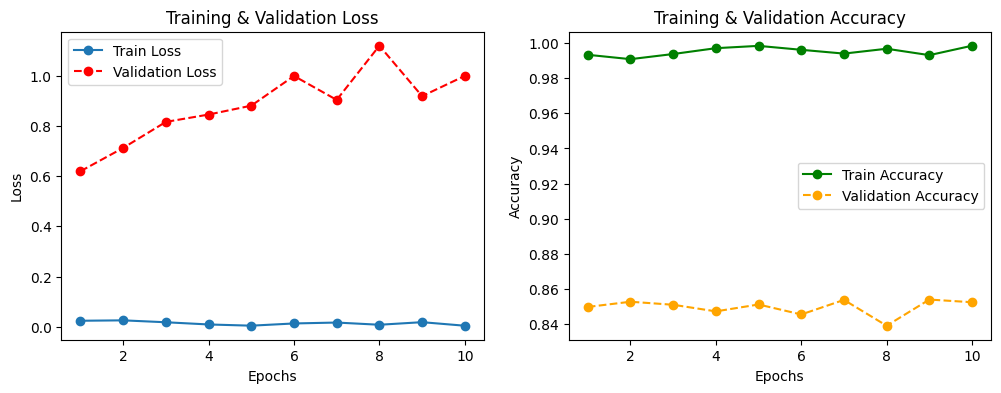

In [128]:
plot_training_history(history_pytorch)

*Step 5: Evaluate the Model**

In [129]:
def evaluate_model(model, test_loader, criterion):
    """
    Evaluates the CNN model on a test dataset.

    Args:
        model (torch.nn.Module): The trained PyTorch model.
        test_loader (DataLoader): DataLoader for test data.
        criterion (torch.nn.Module): Loss function for evaluation.

    Returns:
        dict: Test loss, accuracy, and F1-score.
    """

    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            predictions = torch.argmax(outputs, dim=1)
            y_true.extend(targets.argmax(dim=1).cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

            correct += (predictions == targets.argmax(dim=1)).sum().item()
            total += targets.size(0)

    accuracy = correct / total
    avg_loss = total_loss / len(test_loader)

    class_report = classification_report(y_true, y_pred, output_dict=True)

    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")

    return {
        "Model Name": "PyTorch CNN",
        "Final Validation Accuracy": accuracy,
        "Final Validation Loss": avg_loss,
        "Training Time (sec)": training_time_pytorch,
        "F1-score (Weighted)": class_report["weighted avg"]["f1-score"]
    }

In [130]:
evaluate_model(model_torch, test_loader, criterion)

Test Loss: 0.9985, Test Accuracy: 0.8526


{'Model Name': 'PyTorch CNN',
 'Final Validation Accuracy': 0.85256,
 'Final Validation Loss': 0.9985011447116238,
 'Training Time (sec)': 181.12804174423218,
 'F1-score (Weighted)': 0.8524271844660194}